In [38]:
squares = [x**2 for x in range(1_000_000)]
palindromes_even = [int(str(x) + str(x)[::-1]) for x in range(1, 1_000_000)]
palindromes_odd = [int(str(x) + str(i) +  str(x)[::-1]) for i in range(10) for x in range(1, 1_000_000)]
palindromes = palindromes_even + palindromes_odd
pal_mult_23 = [x for x in palindromes if x % 23 == 0]

In [39]:
print(len(pal_mult_23))
print(pal_mult_23[:2])

478260
[1771, 4554]


In [40]:
N = 1000000000000
fibonacci = [0, 1]
while True:
    next_fib = fibonacci[-1] + fibonacci[-2]
    if next_fib > N:
        break
    fibonacci.append(next_fib)
len(fibonacci)


60

{'A': 'yellow',
 'B': 'magenta',
 'C': 'orange',
 'D': 'green',
 'E': 'purple',
 'F': 'blue',
 'G': 'cyan',
 'H': 'pink',
 'I': 'red',
 'J': 'lightblue',
 'K': 'brown',
 'L': 'grey',
 'M': 'lightgrey'}


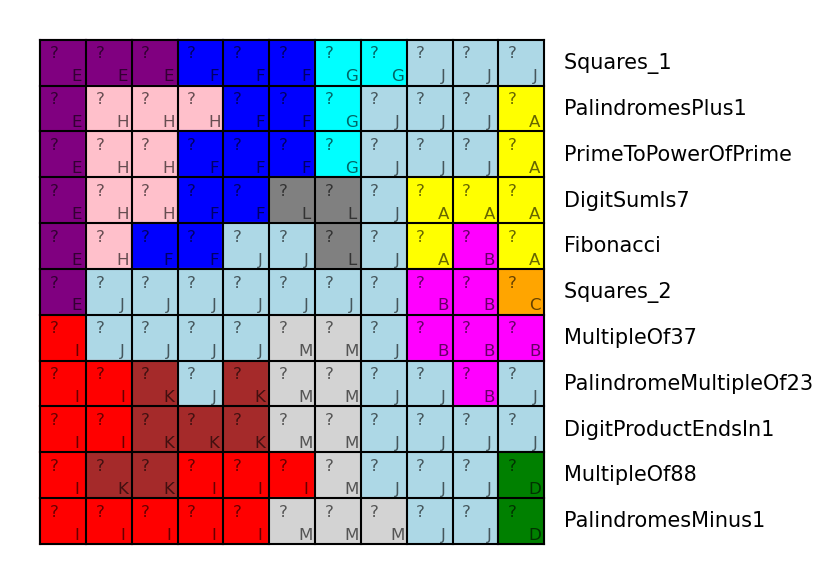

['EEEFFFGGJJJ',
 'EHHHFFGJJJA',
 'EHHFFFGJJJA',
 'EHHFFLLJAAA',
 'EHFFJJLJABA',
 'EJJJJJJJBBC',
 'IJJJJMMJBBB',
 'IIKJKMMJJBJ',
 'IIKKKMMJJJJ',
 'IKKIIIMJJJD',
 'IIIIIMMMJJD']

In [91]:
import abc
from collections import defaultdict
import enum
from pathlib import Path
from pprint import pprint
import string
from matplotlib import pyplot as plt
import random

random.seed(42690)

from matplotlib.patches import Rectangle
import numpy as np

p = Path("input.txt")
assert p.exists()

with p.open() as file:
    MAP = [(l.strip()) for l in file.readlines()]


class Rows(enum.Enum):
    Squares_1 = 0
    PalindromesPlus1 = 1
    PrimeToPowerOfPrime = 2
    DigitSumIs7 = 3
    Fibonacci = 4
    Squares_2 = 5
    MultipleOf37 = 6
    PalindromeMultipleOf23 = 7
    DigitProductEndsIn1 = 8
    MultipleOf88 = 9
    PalindromesMinus1 = 10


class RowLabel:
    def __init__(self, i: int, row: Rows, **kwargs) -> None:
        self.row_index = i
        self.row = row
        self.kwargs = kwargs

    def set(self, **kwargs):
        self.kwargs.update(kwargs)

    def display(self):
        plt.gca().text(
            1.04,
            1 - (self.row_index + 0.5) / 11,
            str(self),
            color="black",
            ha="left",
            va="center",
        )

    def __str__(self) -> str:
        kwargs = [f"{k}={v}" for k, v in self.kwargs.items()]
        kwargs = " ".join(kwargs)
        return f"{self.row.name} {kwargs}"


# Define a color for each distinct character in the map
colors = [
    "lightgrey",
    "lightblue",
    "red",
    "green",
    "blue",
    "yellow",
    "cyan",
    "magenta",
    "grey",
    "purple",
    "orange",
    "brown",
    "pink",
    "lightgreen",
    "lightred",
    "lightblue",
    "lightyellow",
    "lightcyan",
]

def generate_new_color():
    return tuple(np.random.rand(3))

def get_new_group_letter():
    c= chr(ord("A") + len(GROUP_COLORS))
    assert c not in GROUP_COLORS
    assert c in string.ascii_uppercase
    return c

# random.shuffle(colors)
unique_characters = list(set("".join(MAP)) & set("ABCDEFGHIJKLMNOPQRSTUVWXYZ"))
GROUP_COLORS = dict(zip(unique_characters, colors))
pprint(GROUP_COLORS)

KNOWN_VALUES: dict[tuple[int, int], "FieldFact"] = {}


class FieldFact:
    class BoxStatus(enum.Enum):
        UNKNOWN = 0
        PRESENT = 1
        ABSENT = 2

    def __init__(self, x, y, group) -> None:
        self.box_status = FieldFact.BoxStatus.UNKNOWN
        self.number = None
        self.x = x
        self.y = y
        self.group = group

    def __repr__(self) -> str:
        extra = ""
        if self.number is not None:
            extra = f" {self.number}"
        if self.box_status == FieldFact.BoxStatus.PRESENT:
            extra = " X"
        if self.box_status == FieldFact.BoxStatus.ABSENT:
            extra = " O"
        return f"FieldFact({self.x},{self.y},{self.group}{extra})"
    
    def set_digit(self, digit_to_set) -> bool:
        assert 1 <= digit_to_set <= 9
        changed = True
        if self.number is not None:
            assert (
                self.number == digit_to_set
            ), f"Digit already set on field ({self.x},{self.y})"
            changed = False

        self.number = digit_to_set
        self.box_status = FieldFact.BoxStatus.ABSENT

        # Try searching for adjacent neighbours in the same group
        for dx, dy in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
            nx, ny = self.x + dx, self.y + dy
            if neighbour := KNOWN_VALUES.get((ny, nx)):
                if (
                    neighbour.group == self.group
                    and neighbour.box_status == FieldFact.BoxStatus.ABSENT
                    and neighbour.number is None
                ):
                    changed |= neighbour.set_digit(digit_to_set)
        return changed


    def __check_group_divided(self):
        group_candidates = []
        for dx, dy in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
            nx, ny = self.x + dx, self.y + dy
            if neighbour := KNOWN_VALUES.get((ny, nx)):
                if neighbour.group == self.group:
                    group_candidates.append(neighbour)
        if len(group_candidates) <= 1:
            return

        # Check if candidates are connected
        def bfs(start):
            visited = set()
            queue = [start]
            while queue:
                current = queue.pop()
                if current == self:
                    continue
                visited.add(current)
                for dx, dy in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
                    nx, ny = current.x + dx, current.y + dy
                    if neighbour := KNOWN_VALUES.get((ny, nx)):
                        if neighbour.group == self.group and neighbour not in visited:
                            queue.append(neighbour)
            return visited

        groups = {k: bfs(k) for k in group_candidates}
        print(f"{groups=}")
        # If they are still all in the same group, we are done.
        # If we have more groups, we have to create a new letter group for each group
        for i, c1 in enumerate(group_candidates):
            for c2 in group_candidates[1 + i :]:
                if c1 in groups and c2 in groups and c1 in groups[c2]:
                    del groups[c2]
        new_groups = list(groups.values())
        new_groups.pop(0)  # Keep the first group as is, keep the letter

        for i, group in enumerate(new_groups):
            new_group_letter = get_new_group_letter()
            for field in group:
                field.group = new_group_letter
            GROUP_COLORS[new_group_letter] = generate_new_color()

    def set_box_present(self) -> bool:
        if self.box_status == FieldFact.BoxStatus.PRESENT:
            return False
        assert (
            self.number is None
        ), f"Cannot set box on field ({self.x},{self.y}), digit already set to {self.number}"
        assert (
            self.box_status == FieldFact.BoxStatus.UNKNOWN
        ), f"Cannot set box on field ({self.x},{self.y}), box already set"
        self.box_status = FieldFact.BoxStatus.PRESENT

        # Everytime we try and set a box, we also set all neighbours to absent
        for dx, dy in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
            nx, ny = self.x + dx, self.y + dy
            if neighbour := KNOWN_VALUES.get((ny, nx)):
                neighbour.set_box_absent()
        # Check if group is divided
        self.__check_group_divided()
        return True

    def set_box_absent(self) -> bool:
        if self.box_status == FieldFact.BoxStatus.ABSENT:
            return False
        assert (
            self.number is None
        ), f"Cannot set box on field ({self.x},{self.y}), digit already set to {self.number}"
        assert (
            self.box_status == FieldFact.BoxStatus.UNKNOWN
        ), f"Cannot set box on field ({self.x},{self.y}), box already set"
        self.box_status = FieldFact.BoxStatus.ABSENT
        return True

    def display(self):
        x, y = self.x, self.y
        coords = np.array([x, 10 - y]).astype(float) / 11

        # Display underlying colored square
        r = Rectangle(coords, 1 / 11, 1 / 11, color=GROUP_COLORS[self.group])
        plt.gca().add_patch(r)
        groupname_text_coords = coords + np.array([+0.8, +0.2]) / 11

        plt.gca().text(
            *groupname_text_coords,
            self.group,
            color="black",
            ha="center",
            va="center",
            fontdict={"size": 8},
            alpha=0.6,
        )

        textcoords = coords + np.array([+0.5, +0.5]) / 11
        if self.number is not None:
            # Display number if present
            plt.gca().text(
                *textcoords,
                self.number,
                color="black",
                ha="right",
                va="center",
                fontdict={"size": 12},
            )
        else:
            # Say some info about box status: BLACK if there is a box, question mark bottom left if unknown, nothing if box absent
            if self.box_status == FieldFact.BoxStatus.PRESENT:
                w = 0.09
                r = Rectangle(coords, w, w, color="black", alpha=1)
                plt.gca().add_patch(r)
            elif self.box_status == FieldFact.BoxStatus.UNKNOWN:
                textcoords = coords + np.array([+0.3, +0.7]) / 11
                plt.gca().text(
                    *textcoords,
                    "?",
                    color="black",
                    ha="center",
                    va="center",
                    fontdict={"size": 8},
                    alpha=0.6,
                )


ROW_LABELS = {row: RowLabel(i, row) for i, row in enumerate(Rows)}


# Read map
for y, row in enumerate(MAP):
    for x, group_char in enumerate(row):
        KNOWN_VALUES[(y, x)] = FieldFact(x, y, group_char)


def print_map():
    # Create a figure and axis
    plt.figure(dpi=150)
    ax: plt.Axes = plt.gca()
    # Draw the map
    for field in KNOWN_VALUES.values():
        field.display()
    # Print lines
    for i in range(12):
        ax.plot([0, 1], [i / 11, i / 11], color="black", lw=1)
        ax.plot([i / 11, i / 11], [0, 1], color="black", lw=1)
    for rl in ROW_LABELS.values():
        rl.display()

    # Set the aspect of the plot to be equal
    ax.set_aspect("equal")
    # Remove the axes
    ax.axis("off")
    # Display the plot
    plt.show()


def get_row_values(row: Rows):
    return MAP[row.value]


print_map()
MAP


In [92]:
import functools
%pip install tqdm ipywidgets
from tqdm.notebook import tqdm

# To disable printing, set this to false.
ENABLE_PRINT = False

@functools.lru_cache
def count_generator(generator):
    return sum(1 for _ in generator())

def decorated_tqdm(total_number=None):
    def decorator(generator_func):
        total = (
            count_generator(generator_func) if total_number is None else total_number
        )
        @functools.wraps(generator_func)
        def wrapper(*args, do_print=True, **kwargs):
            if ENABLE_PRINT and do_print:
                fn_name = generator_func.__name__
                return tqdm(
                    generator_func(*args, **kwargs),
                    total=total,
                    desc=f"Generating {fn_name}",
                    unit="numbers",
                )
            else:
                return generator_func(*args, **kwargs)

        return wrapper

    return decorator


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [93]:

MAX_N = 100_000_000_000
GENERATORS = {}

@decorated_tqdm()
def g_squares():
    # Output numbers must be at least 2 characters long
    x = 4
    n = x**2
    while n < MAX_N:
        yield n
        x += 1
        n = x**2


GENERATORS[Rows.Squares_1] = g_squares
GENERATORS[Rows.Squares_2] = g_squares


@decorated_tqdm()
def g_fibonnaci():
    a, b = 1, 1
    while a < 10:
        a, b = b, a + b
    while a < MAX_N:
        yield a
        a, b = b, a + b


GENERATORS[Rows.Fibonacci] = g_fibonnaci


@decorated_tqdm(total_number=MAX_N // 37)
def g_multiple_of_37():
    n = 37
    while n < MAX_N:
        yield n
        n += 37


GENERATORS[Rows.MultipleOf37] = g_multiple_of_37


@decorated_tqdm(total_number=MAX_N // 88)
def g_multiple_of_88():
    n = 88
    while n < MAX_N:
        yield n
        n += 88


GENERATORS[Rows.MultipleOf88] = g_multiple_of_88


@decorated_tqdm(total_number=109989)
def g_palindromes():
    a, b = 1, 10
    while b < 100_000:
        for i in range(a, b):
            si = str(i)
            sio = si[::-1]
            yield int(si + sio)

        for i in range(a, b):
            for j in range(10):
                si = str(i)
                if not a:
                    continue
                sio = si[::-1]
                yield int(f"{i}{j}{sio}")

        a = b
        b *= 10


@decorated_tqdm(total_number=109989)
def g_palindromes_plus1():
    for paly in g_palindromes(do_print=False):
        yield paly + 1


GENERATORS[Rows.PalindromesPlus1] = g_palindromes_plus1


@decorated_tqdm(total_number=109989)
def g_palindromes_minus1():
    for paly in g_palindromes(do_print=False):
        yield paly - 1


GENERATORS[Rows.PalindromesMinus1] = g_palindromes_minus1


@decorated_tqdm(total_number=478260)
def g_palindrome_multiple_of_23():
    for paly in g_palindromes(do_print=False):
        if paly % 23 != 0:
            continue
        yield paly

GENERATORS[Rows.PalindromeMultipleOf23] = g_palindrome_multiple_of_23

In [94]:
# Assert they are increasing
last = None
num_paly_generated = 0

def count_from_generator(generator):
    return sum(1 for _ in generator)

for paly in g_palindromes():
    assert last is None or paly > last, f"{paly=} {last=}"
    num_paly_generated += 1
    last = paly

print(f"{num_paly_generated=}")
print(f"{len(list(g_palindrome_multiple_of_23()))=}")


num_paly_generated=109989
len(list(g_palindrome_multiple_of_23()))=4781


In [95]:
# Digit mask

"""
We get a mask, say 'aab'
We want to return a number that matches the mask in its digits.
"""
from collections import defaultdict
from typing import Any, Generator, Iterable
from string import ascii_uppercase

# We want the i to spit out numbers that are increasing


def number_to_mask(n: int):
    """
    Returns a mask for the number
    Example: 1234 -> 'abcd', 1233 -> 'abcc'
    """
    chars = list(ascii_uppercase)
    mask_d = {}
    mask = ""
    for d in str(n):
        if d not in mask_d:
            mask_d[d] = chars.pop(0)
        mask += mask_d[d]
    return mask


def normalize_mask(mask: str, non_connected_groups_are_the_same=True):
    """
    Returns a normalized mask
    Example: 'ca66' -> 'abcc'
    """
    if non_connected_groups_are_the_same:
        mask_d = {}
        chars = list(ascii_uppercase)
        for m in mask:
            if m in string.digits:
                mask_d[m] = m
            if m not in mask_d:
                mask_d[m] = chars.pop(0)
        return "".join(mask_d[m] for m in mask)

    # Handle the case where non connected groups are percieved different
    mask_backref = {}
    for i, m in enumerate(mask):
        if i != 0 and m == mask[i - 1]:
            mask_backref[i] = mask_backref[i - 1]
        else:
            mask_backref[i] = i
    mask_d = {}
    chars = list(ascii_uppercase)
    for i, m in enumerate(mask):
        if mask_backref[i] not in mask_d:
            if m in string.digits:
                mask_d[mask_backref[i]] = m
            else:
                mask_d[mask_backref[i]] = chars.pop(0)
    return "".join(mask_d[mask_backref[i]] for i in range(len(mask)))


def extract_masks_from_generator(i: Generator[int, Any, None]):
    "Returns all the masks that are present in the generator"
    P = defaultdict(list)
    for n in i:
        mask = number_to_mask(n)
        P[mask].append(n)
    return P


def number_matches_mask_bijection(n: int, mask: str):
    # Try to construct a bijection between the mask and the digits
    M = {}
    n = str(n)
    for m, d in zip(mask, n):
        if m in "0123456789":
            # If we have a digit in the mask, it must match the digit in the number
            print("!!!! MASK NUMBER")
            if m != d:
                return False
        if m in M and M[m] != d or d in M and M[d] != m:
            return False
        M[m] = d
        M[d] = m
    return True

def number_matches_mask_border(n: int, mask: str):
    # Less strict: if mask changes, also change the number
    n = str(n)
    if len(n) != len(mask):
        return False
    for i, m in enumerate(mask[1:],1):
        if not (
            (m == mask[i - 1]) == (n[i] == n[i - 1])
        ):
            return False
    return True


def generator_filter_mask(i: Generator[int, Any, None], mask: str):
    "IMPORTANT!"
    """
    If mask looks like this AABAC, the first group of As isn't necessarily the same as the second group of As.
    """
    for n in i:
        n = str(n)
        if len(n) < len(mask):
            continue
        if len(n) > len(mask):
            break
        if number_matches_mask_border(n, mask):
            yield n
    i.close()

for digit_to_set in generator_filter_mask(g_palindrome_multiple_of_23(), "aba"):
    print(digit_to_set)

161
414
575
828
989


In [96]:
# __

# ___
# X__
# __X

# ____
# ___X
# X___
# X__X

from typing import List


def get_possible_boxes(row: Rows=None):
    # We only generate configurations, that adhere to already-known values
    if row:
        row_box_status = [KNOWN_VALUES[(row.value, i)].box_status for i in range(11)]
    else:
        row_box_status = [FieldFact.BoxStatus.UNKNOWN] * 11
    # Each space must be at least 2 apart.
    for i in range(2**11-1, -1 ,-1):
        a = f"{i:011b}"
        if "101" in a:
            continue
        if "11" in a:
            continue
        if a[1] == "1" or a[-2] == "1":
            continue
        for j, c in enumerate(a):
            if row_box_status[j] == FieldFact.BoxStatus.PRESENT and c != "1":
                break
            if row_box_status[j] == FieldFact.BoxStatus.ABSENT and c != "0":
                break
        else:
            yield i

def get_masks_and_ranges(row_without_boxes: List[str], boxes_mask:int):
    assert len(row_without_boxes) == 11
    assert 0 <= boxes_mask < 2**11
    last = ""
    last_i = 0
    # Get ranges between boxes
    for i, field in enumerate(row_without_boxes):
        if (boxes_mask & 1<<(10-i)):
            # There is a box at this place
            if last:
                assert len(last) == i - last_i
                yield last, (last_i, i)
                last = ""
            last_i = i+1
        else:
            last += field
    if last:
        yield (last, (last_i, 11))

def count_boxes(a:Rows=None):
    c = 0
    for b in get_possible_boxes(a):
        #print(f"{b:011b}")
        c+=1
    return c

f"{count_boxes()=}"

'count_boxes()=54'

In [97]:
# We known 2nd column and 2nd to last column can't have a box

for row_i in range(11):
    KNOWN_VALUES[(row_i, 1)].set_box_absent()
    KNOWN_VALUES[(row_i, 9)].set_box_absent()


In [98]:
from typing import Dict, Optional, Set, Tuple


def get_fixed_points_from_configuratoin(configuration: Dict[Tuple[int, int], Set[str]]):
    "This function gets the fixed points from a configuration."
    """
    Example input: {(0,2):{"12"}, (5,8):{"123", "124"}} -> fixed points: {0:1, 1:2, 5:1, 6:2}
    """
    configuration_fixpoints: Dict[int, Optional[Set[str]]] = {
        i: None for i in range(11)
    }
    for (start_pos, end_pos), candidate_values in configuration.items():
        for candidate_value in candidate_values:
            for character_index, character in zip(
                range(start_pos, end_pos), str(candidate_value)
            ):
                if configuration_fixpoints[character_index] is None:
                    configuration_fixpoints[character_index] = set(character)
                else:
                    configuration_fixpoints[character_index].intersection_update(
                        character
                    )
    return {
        i: tuple(v)[0] for i, v in configuration_fixpoints.items() if v and len(v) == 1
    }


class RowAttemptContext:
    " Create an instance, when you start doing attempts in a row, and then register every possible attempt. "
    " This class keeps track of constants that are shared across all attempts in a row and can be used to deduce facts."
    def __init__(self, row: Rows) -> None:
        self.box_fixpoints_present = None
        self.box_fixpoints_absent = None
        self.row = row
        self.num_box_configurations = 0
        # Track only possible options across all the boxes
        self.character_fixpoint_votes = defaultdict(int)
        self.is_possible_to_know_something = 0b111

    def add_box_possibility(self, boxes: int) -> bool:
        " boxes is 12-bit string"
        " Returns True, if it isn't satisfiable "
        if self.box_fixpoints_present is None:
            self.box_fixpoints_present = self.box_fixpoints_absent = boxes
        else:
            self.box_fixpoints_present &= boxes  # Restriction regarding 1s
            if self.box_fixpoints_present == 0:
                print("WARN: No boxes can be definitly present")
                self.is_possible_to_know_something &= 0b101
            self.box_fixpoints_absent |= boxes  # Restriction regarding 0s
            if self.box_fixpoints_absent == 0b11111111111:
                print("WARN: No boxes can be definitly absent")
                self.is_possible_to_know_something &= 0b011

        return self.is_possible_to_know_something == 0


    def add_digit_possibilities(self, configuration: Dict[Tuple[int, int], Set[str]]):
        " Returns True, if it isn't satisfiable "
        config_fixpoints = get_fixed_points_from_configuratoin(configuration)
        if len(config_fixpoints) == 0:
            print("WARN: There are no definite digits in this configuration")
            self.is_possible_to_know_something &= 0b110
        for k, v in config_fixpoints.items():
            self.character_fixpoint_votes[(k, v)] += 1
        self.num_box_configurations += 1

        return self.is_possible_to_know_something == 0


    def _get_fixed_characters(self):
        # print(f"{character_fixpoint_votes=}")
        self.known_row_values = {}
        for (
            character_index,
            character,
        ), fixpoint_occurances in self.character_fixpoint_votes.items():
            if fixpoint_occurances != self.num_box_configurations:
                continue
            yield character_index, character

    def _get_fixed_boxes(self):
        if self.box_fixpoints_present is not None:
            for i in range(11):
                if self.box_fixpoints_present & 1 << (10 - i):
                    yield i, "PRESENT"

        if self.box_fixpoints_absent is not None:
            print(f"{self.box_fixpoints_absent=:011b}")
            for i in range(11):
                if not (self.box_fixpoints_absent & 1 << (10 - i)):
                    yield i, "ABSENT"

    def print_fixed_facts(self):
        print(f"Row {self.row.name} has the following fixed facts:")
        print(f"\tdistinct_box_configs={self.num_box_configurations}") 
        for box_i, state in self._get_fixed_boxes():
            print(f"\tRow {self.row.name} Box {box_i} is {state}")
        for character_index, character in self._get_fixed_characters():
            print(f"\tRow {self.row.name} Character {character_index} is {character}")

    def update_state(self):
        changed = False
        for character_index, character in self._get_fixed_characters():
            changed |= KNOWN_VALUES[(self.row.value, character_index)].set_digit(int(character))
        for box_i, state in self._get_fixed_boxes():
            if state == "PRESENT":
                changed |= KNOWN_VALUES[(self.row.value, box_i)].set_box_present()
            if state == "ABSENT":
                changed |= KNOWN_VALUES[(self.row.value, box_i)].set_box_absent()
        return changed


Squares_1
	Impossible box at 2
	Impossible box at 8
PalindromesPlus1
	No generator for PrimeToPowerOfPrime
	No generator for DigitSumIs7
Fibonacci
Squares_2
MultipleOf37
	Impossible box at 8
PalindromeMultipleOf23
	Impossible box at 2
	Impossible box at 8
	No generator for DigitProductEndsIn1
MultipleOf88
	Impossible box at 2
	Impossible box at 8
PalindromesMinus1
	Impossible box at 2


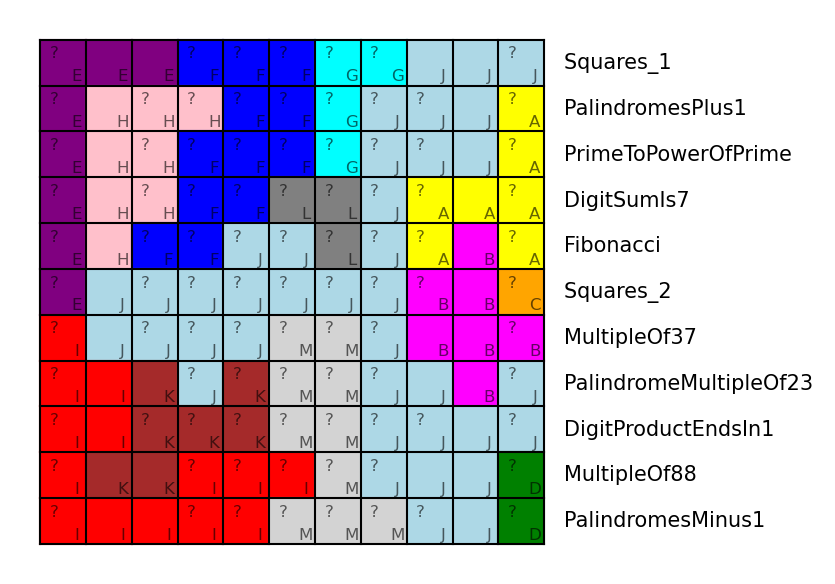

In [99]:
# Do some stupid:
## Try placing a box on column 3 (index 2), and try to generate any valid number for the mask. If none can be generated, we have a contradiction

for i, row in enumerate(Rows):
    map_values = get_row_values(row)
    # "Placing a box in front"
    mask_head = map_values[:2]
    mask_tail = map_values[-2:]
    generator_factory = GENERATORS.get(row)
    if not generator_factory:
        print(f"\tNo generator for {row.name}")
        continue
    print(row.name)
    if not list(generator_filter_mask(generator_factory(do_print=False), mask_head)):
        KNOWN_VALUES[(row.value, 2)].set_box_absent()
        print("\tImpossible box at 2")
    if not list(generator_filter_mask(generator_factory(do_print=False), mask_tail)):
        KNOWN_VALUES[(row.value, 8)].set_box_absent()
        print("\tImpossible box at 8")
print_map()

Valid configuration: 10000100001
Valid configuration: 00000001000
WARN: No boxes can be definitly present
Row PalindromeMultipleOf23 has the following fixed facts:
	distinct_box_configs=0
self.box_fixpoints_absent=10000101001
	Row PalindromeMultipleOf23 Box 1 is ABSENT
	Row PalindromeMultipleOf23 Box 2 is ABSENT
	Row PalindromeMultipleOf23 Box 3 is ABSENT
	Row PalindromeMultipleOf23 Box 4 is ABSENT
	Row PalindromeMultipleOf23 Box 6 is ABSENT
	Row PalindromeMultipleOf23 Box 8 is ABSENT
	Row PalindromeMultipleOf23 Box 9 is ABSENT
self.box_fixpoints_absent=10000101001


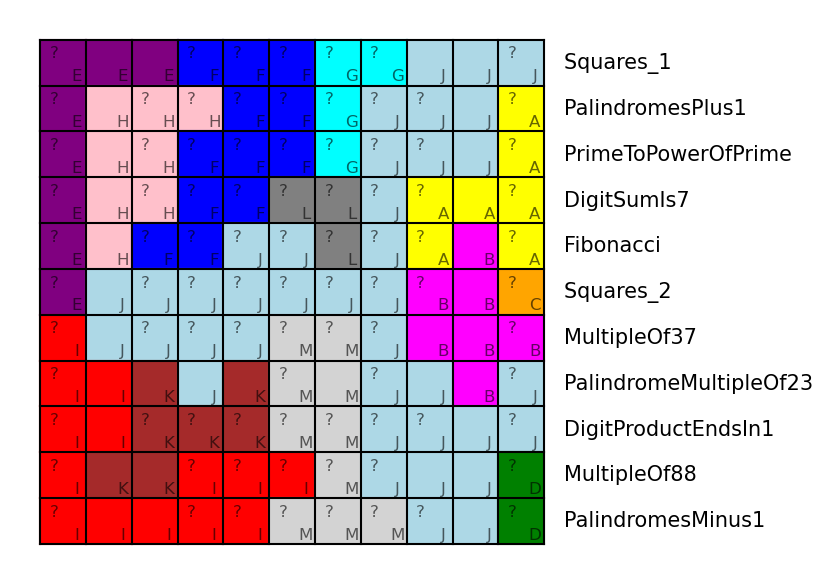

In [100]:
# Palindromes 23 attempts

def mask_to_tuple(mask:str):
    " Converts 'aabccca' to (2, 1, 3, 1) "
    l = []
    last = None
    for c in mask:
        if c == last:
            l[-1] += 1
        else:
            l.append(1)
            last = c
    return tuple(l)

def can_mask_be_palindrome(mask: str):
    t = mask_to_tuple(mask)
    return t == t[::-1]

row_attempt_context = RowAttemptContext(Rows.PalindromeMultipleOf23)
for box_config in get_possible_boxes():
    for mask, rng in get_masks_and_ranges(get_row_values(Rows.PalindromeMultipleOf23), box_config):
        if len(mask) == 2: break # No 23 palindrome can be 2 characters long
        if not can_mask_be_palindrome(mask):
            break
    else:
        print(f"Valid configuration: {box_config:011b}")
        row_attempt_context.add_box_possibility(box_config)

row_attempt_context.print_fixed_facts()
row_attempt_context.update_state()
print_map()

In [105]:
from pprint import pprint
from typing import Dict, List, Optional, Set
from collections import defaultdict
import numpy as np

def generate_possible_box_number_configurations(row:Rows):
    # Track only possible options across all the boxes
    generator_factory = GENERATORS[row]
    rowvalues = get_row_values(row)
    for boxes in get_possible_boxes(row):
        configuration = {}
        for mask, rng in get_masks_and_ranges(rowvalues, boxes):
            configuration[rng] = list(generator_filter_mask(generator_factory(do_print=False), mask))
        if any(not v for v in configuration.values()):
            continue
        yield boxes, configuration

def attempt_row(row: Rows) -> bool:
    total_possible_arrangements = 0

    # Track boxes throughout all possible valid configurations. If there is a box in a place in all configurations, it must be there.
    row_attempt_context = RowAttemptContext(row)
    num_configs = 0
    
    if row not in GENERATORS:
        print("No generator for this row. Skipping.")
        return False
    
    for boxes, config in generate_possible_box_number_configurations(row):
        num_configs += 1

        arrangements_in_config = np.prod([len(v) for v in config.values()])
        total_possible_arrangements += arrangements_in_config
        
        row_attempt_context.add_digit_possibilities(config)
        if row_attempt_context.add_box_possibility(boxes):
            break
        # print(f"\t{boxes:011b}")
        # pprint(config)
    else:
        print(f"{total_possible_arrangements=}")
        print(f"{num_configs=}")
        ROW_LABELS[row].set(total_possible=total_possible_arrangements, box_conf=num_configs)
        row_attempt_context.print_fixed_facts()
        return row_attempt_context.update_state()
    return False

# worth_rows = list(range(11))
# worth_rows.remove(Rows.MultipleOf37.value); # worth_rows.append(Rows.MultipleOf37.value)
# worth_rows.remove(Rows.MultipleOf88.value); # worth_rows.append(Rows.MultipleOf88.value)
def attempt_worth_rows():
    worth_rows = [
        Rows.PalindromeMultipleOf23,
        Rows.Squares_1,
        Rows.PalindromesPlus1,
        Rows.Fibonacci,
        Rows.Squares_2,
        Rows.PalindromesMinus1,
        # Rows.MultipleOf37, # Very slow ~5mins
        # Rows.MultipleOf88, # Very slow ~5mins
    ]
    changed = False
    for row in worth_rows:
        row = Rows(row)
        print("Attempting row:", row)
        changed |= attempt_row(row)
    return changed

Iteration 1
Running attempt_worth_rows
Attempting row: Rows.PalindromeMultipleOf23
WARN: There are no definite digits in this configuration
total_possible_arrangements=145
num_configs=1
Row PalindromeMultipleOf23 has the following fixed facts:
	distinct_box_configs=1
	Row PalindromeMultipleOf23 Box 7 is PRESENT
self.box_fixpoints_absent=00000001000
	Row PalindromeMultipleOf23 Box 0 is ABSENT
	Row PalindromeMultipleOf23 Box 1 is ABSENT
	Row PalindromeMultipleOf23 Box 2 is ABSENT
	Row PalindromeMultipleOf23 Box 3 is ABSENT
	Row PalindromeMultipleOf23 Box 4 is ABSENT
	Row PalindromeMultipleOf23 Box 5 is ABSENT
	Row PalindromeMultipleOf23 Box 6 is ABSENT
	Row PalindromeMultipleOf23 Box 8 is ABSENT
	Row PalindromeMultipleOf23 Box 9 is ABSENT
	Row PalindromeMultipleOf23 Box 10 is ABSENT
self.box_fixpoints_absent=00000001000
Attempting row: Rows.Squares_1
WARN: There are no definite digits in this configuration
WARN: No boxes can be definitly present
total_possible_arrangements=6
num_configs=

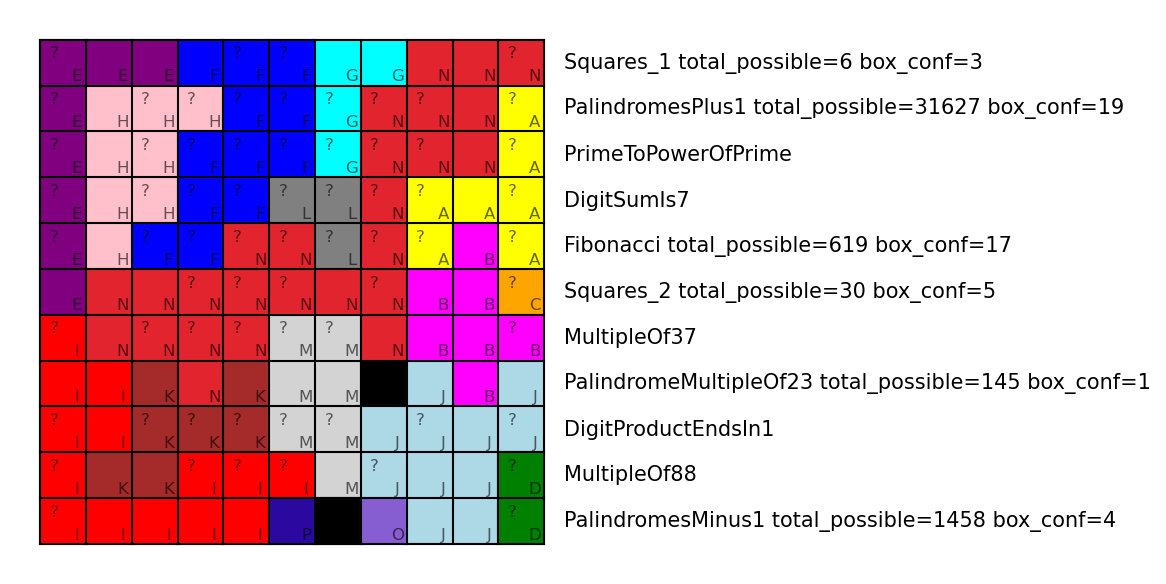

Done. Final iteration count: 1


In [108]:
state_searching_functions = [
    # These return True if they have found anything
    attempt_worth_rows
]

changed = True
iteration = 1
while changed:
    changed = False
    print(f"Iteration {iteration}")
    for fn in state_searching_functions:
        print(f"Running {fn.__name__}")
        changed |= fn()
    print_map()
print("Done. Final iteration count:", iteration)


In [107]:
# program for weak compositions of 7
def compositions(n):
    if n == 1:
        return [[1]]
    else:
        return [[x] + y for x in range(n + 1) for y in compositions(n - x)] 
compositions(7)


RecursionError: maximum recursion depth exceeded in comparison